# I- Library Imports

In [99]:
# ! pip install ijson
#! pip install chardet
#! pip install tf-keras
#! pip install bertopic 
#! pip install wordcloud
#! pip install sentence-transformers hdbscan umap-learn


In [1]:
#from time import time
import os
import ast
import string
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import trigrams

import spacy
from spacy.lang.en.stop_words import STOP_WORDS


from wordcloud import WordCloud

import gensim
import gensim.corpora as corpora
import gensim.models.ldamodel as lda

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from pyLDAvis import gensim

from flask import Flask, render_template

from bertopic import BERTopic



import umap

os.getcwd()

'c:\\Users\\eadk\\Desktop\\artefact_curriculum\\projet'

In [2]:
nltk.download('punkt')       # For word tokenization
nltk.download('stopwords')   # For stopwords
nltk.download('wordnet')     # For lemmatization
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eadk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eadk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eadk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eadk\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
#! python -m spacy download en_core_web_lg

# II- Load Data

# II-A. INFO FOR ALL BUSINESSES 

In [4]:
%%time

business_file_to_open_json = 'data/yelp_academic_dataset_business.json'

business_list = [json.loads(line) for line in open(business_file_to_open_json, 'r', errors='replace') ]

print(type(business_list),len(business_list))

<class 'list'> 150346
CPU times: total: 812 ms
Wall time: 4.9 s


In [5]:
print(type(business_list[0]))

business_list[0]

<class 'dict'>


{'business_id': 'Pns2l4eNsfO8kk83dixA6A',
 'name': 'Abby Rappoport, LAC, CMQ',
 'address': '1616 Chapala St, Ste 2',
 'city': 'Santa Barbara',
 'state': 'CA',
 'postal_code': '93101',
 'latitude': 34.4266787,
 'longitude': -119.7111968,
 'stars': 5.0,
 'review_count': 7,
 'is_open': 0,
 'attributes': {'ByAppointmentOnly': 'True'},
 'categories': 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
 'hours': None}

# II-B. INFO FOR JUST RESTAURANT BUSINESSES

In [6]:
%%time

restaurant_list = [item for item in business_list if item.get('categories') and 'Restaurant' in item['categories']]
restaurant_ids = [item['business_id'] for item in restaurant_list]
                  
print(len(restaurant_list), len(restaurant_ids))
print(restaurant_ids[0:5])

restaurant_list[0]

52286 52286
['MTSW4McQd7CbVtyjqoe9mw', 'CF33F8-E6oudUQ46HnavjQ', 'k0hlBqXX-Bt0vf1op7Jr1w', 'bBDDEgkFA1Otx9Lfe7BZUQ', 'eEOYSgkmpB90uNA7lDOMRA']
CPU times: total: 15.6 ms
Wall time: 123 ms


{'business_id': 'MTSW4McQd7CbVtyjqoe9mw',
 'name': 'St Honore Pastries',
 'address': '935 Race St',
 'city': 'Philadelphia',
 'state': 'PA',
 'postal_code': '19107',
 'latitude': 39.9555052,
 'longitude': -75.1555641,
 'stars': 4.0,
 'review_count': 80,
 'is_open': 1,
 'attributes': {'RestaurantsDelivery': 'False',
  'OutdoorSeating': 'False',
  'BusinessAcceptsCreditCards': 'False',
  'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
  'BikeParking': 'True',
  'RestaurantsPriceRange2': '1',
  'RestaurantsTakeOut': 'True',
  'ByAppointmentOnly': 'False',
  'WiFi': "u'free'",
  'Alcohol': "u'none'",
  'Caters': 'True'},
 'categories': 'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
 'hours': {'Monday': '7:0-20:0',
  'Tuesday': '7:0-20:0',
  'Wednesday': '7:0-20:0',
  'Thursday': '7:0-20:0',
  'Friday': '7:0-21:0',
  'Saturday': '7:0-21:0',
  'Sunday': '7:0-21:0'}}

# II-C. LOAD ALL REVIEWS LIST

In [7]:
%%time

reviews_file_to_open_json = 'data/yelp_academic_dataset_review.json'

review_list = [json.loads(line) for line in open(reviews_file_to_open_json, 'r', errors='replace') 
               ]

print(type(review_list),len(review_list))

review_list[0]

<class 'list'> 6990280
CPU times: total: 17.5 s
Wall time: 2min 4s


{'review_id': 'KU_O5udG6zpxOg-VcAEodg',
 'user_id': 'mh_-eMZ6K5RLWhZyISBhwA',
 'business_id': 'XQfwVwDr-v0ZS3_CbbE5Xw',
 'stars': 3.0,
 'useful': 0,
 'funny': 0,
 'cool': 0,
 'text': "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.",
 'date': '2018-07-07 22:09:11'}

# II-D. REVIEWS FOR ONLY LOW SCORE RESTAURANTS 

In [8]:
%%time
number_low_score_reviews_selected = 500000

review_list_low_score = [item for item in review_list[0:number_low_score_reviews_selected] if (item['stars'] <= 2) and (item['business_id'] in restaurant_ids)]
print(len(review_list_low_score))

review_list_low_score[0:5]

68289
CPU times: total: 1min 17s
Wall time: 3min 33s


[{'review_id': 'JrIxlS1TzJ-iCu79ul40cQ',
  'user_id': 'eUta8W_HdHMXPzLBBZhL1A',
  'business_id': '04UD14gamNjLY0IDYVhHJg',
  'stars': 1.0,
  'useful': 1,
  'funny': 2,
  'cool': 1,
  'text': "I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) and was told they're too busy to do it. Really? The place is maybe half full at best. Does your dick reach your ass? Yes? Go fuck yourself! I'm a frequent customer AND great tipper. Glad that Kanella just opened. NEVER going back to dmitris!",
  'date': '2015-09-23 23:10:31'},
 {'review_id': 'elqRpX9T3YwL07uLNtN3Bg',
  'user_id': '-sryo4gDYxbZ1T5Bz4l5Bw',
  'business_id': 'ltBBYdNzkeKdCNPDAsxwAA',
  'stars': 2.0,
  'useful': 0,
  'funny': 0,
  'cool': 0,
  'text': 'I at least have to give this restaurant two stars due to the decent food. But while on a dinner meeting and after spending $100 on entrées and appetizers, I had to flag down the assistant cook, (the guy in bright red baggy pants watching 

In [9]:
resto_reviews_df = pd.DataFrame(review_list_low_score)
print(resto_reviews_df.shape, resto_reviews_df.columns)
resto_reviews_df.head()

(68289, 9) Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
1,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
2,RB8UpF_kT2xoOC51OzXEeA,EZjT2qJN0mOXypMAqZdSrQ,A2q7d-CBM2-81tVkmS4JMw,2.0,1,1,0,"Straight to the point, it's cheap, it tastes a...",2017-07-08 18:58:42
3,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12
4,yCbzm_d4cHpfUX00Ljvgmg,bHSoye7R5cL-LVWLxtaxMg,SSZDGl2J-CEyIzuIbEiYNQ,2.0,2,0,0,"We started with the artichoke dip, big mistake...",2017-09-08 23:20:19


# III- CLEANING

In [10]:
def clean_data_spacy(text):
    
    # Load the English model
    nlp = spacy.load('en_core_web_lg')
            
    # Define stopwords (including spaCy's stopwords)
    stop_words = set(STOP_WORDS)
    
    
    #OT NEEDED B/C COULD NEED NAMED ENTITY RECIGNITION: Convert all text to lowercase to ensure uniformity. 
    #text = text.lower()


    # Process the text
    doc = nlp(text)

    # Filter out stopwords, but keep adverbs (ADV) and adjectives (ADJ)
    tokens = [token.lemma_ for token in doc if ( (token.text.lower() not in stop_words) 
                                              # or (token.pos_ in {'VERB', 'PART', 'ADV', 'ADJ'}) )
                                                or (token.pos_ in {'VERB', 'ADV', 'ADJ'}) )
                                            and (not token.is_punct)
                                              ] 
       
    # Remove Non-Alphabetic Characters (e.g., numbers, special characters)
    tokens = [token for token in tokens if token.isalpha()]
    
    #domain_stop_words = ['restaurant', 'one', 'well', 'think', 'come', 'go', 'back','say', 'know', 'make']
    domain_stop_words = ['restaurant', 'one', 'well', 'think', 'come',  'back','say', 'know', 'make']
    tokens = [token for token in tokens if token not in domain_stop_words ]
    

    # Optional - Handle Common Terms REMOVE or KEEP domain-specific COMMON TERMS THAT DOMINATE the clustering results.

    # Optional - N-grams CREATE bi-grams or tri-grams to capture common phrases if single words aren't sufficient for topic modeling.
    
    #bigram = Phrases(tokens, min_count=5, threshold=100)
    #tokens = bigram[tokens]
    
    return tokens



In [11]:
def clean_data_nltk(text):
    
    #Convert all text to lowercase to ensure uniformity. 
    text = text.lower()

    # Remove punctuation b/c NOT CONTRIBUTING TO topic modeling.    
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Split the text into individual words (tokens).    
    tokens = word_tokenize(text)
    
    # GET POS (parts of speech) of tokens
    # adverbs have (RB, RBR, RBS) and adjectives have (JJ, JJR, JJS).
    pos_tags = pos_tag(tokens)
    
    # Remove stop words like "b/c NOT CONTRIBUTING TO topic modeling    
    stop_words = set(stopwords.words('english'))
    # print('too' in stop_words)
    
    # tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word, pos in pos_tags if word not in stop_words  
                                                or 
                                                pos.startswith(('RB', 'JJ'))]
    

    # Stemming/Lemmatization to REDUCE BASE forms (lemmatization) to minimize redundancy (STEMMING IS ROOT FORM - CAN BE MEANINGLESS WORDS)    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove Non-Alphabetic Characters (e.g., numbers, special characters)
    tokens = [word for word in tokens if word.isalpha()]
    domain_stop_words = ['restaurant', 'one', 'well', 'think', 'come', 'go', 'back','say', 'know', 'make']
    tokens = [token for token in tokens if token not in domain_stop_words ]

    # Optional - Handle Common Terms REMOVE or KEEP domain-specific COMMON TERMS THAT DOMINATE the clustering results.

    # Optional - N-grams CREATE bi-grams or tri-grams to capture common phrases if single words aren't sufficient for topic modeling.
    
    #bigram = Phrases(tokens, min_count=5, threshold=100)
    #tokens = bigram[tokens]
    
    return tokens



In [12]:
print(clean_data_spacy("I just went in to order take out (3 apps) and was told they're too busy to do it"))

clean_data_nltk("I just went in to order take out (3 apps) and was told they're too busy to do it")

['just', 'go', 'order', 'take', 'app', 'tell', 'too', 'busy', 'do']


['just', 'went', 'order', 'take', 'apps', 'told', 'theyre', 'too', 'busy']

In [13]:
%%time
#resto_reviews_df['cleaned_tokens'] = resto_reviews_df['text'].apply(clean_data_nltk)
resto_reviews_df['cleaned_tokens'] = resto_reviews_df['text'].apply(clean_data_spacy)
print(resto_reviews_df.shape)
resto_reviews_df['cleaned_tokens']


In [69]:
resto_reviews_df['text'].iloc[0]

"I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) and was told they're too busy to do it. Really? The place is maybe half full at best. Does your dick reach your ass? Yes? Go fuck yourself! I'm a frequent customer AND great tipper. Glad that Kanella just opened. NEVER going back to dmitris!"

In [70]:
print(resto_reviews_df['cleaned_tokens'].iloc[0])

['long', 'term', 'frequent', 'customer', 'establishment', 'just', 'went', 'order', 'take', 'apps', 'told', 'theyre', 'too', 'busy', 'really', 'place', 'maybe', 'half', 'full', 'best', 'dick', 'reach', 'as', 'yes', 'fuck', 'im', 'frequent', 'customer', 'great', 'tipper', 'glad', 'kanella', 'just', 'opened', 'never', 'going', 'back', 'dmitris']


In [72]:
# Join Tokens Back into Strings. BERTopic expects full sentences rather than lists of tokens:

resto_reviews_df['cleaned_reviews'] = resto_reviews_df['cleaned_tokens'].apply(lambda x: ' '.join(x))
resto_reviews_df['cleaned_reviews']


0        long term frequent customer establishment just...
1        least give two star due decent food dinner mee...
2        straight point cheap taste feel cheap good pri...
3        want pay everything la carte place food wasnt ...
4        started artichoke dip big mistake cold chip st...
                               ...                        
68284    ambiance great waitress menu everyone excited ...
68285    place overpriced salty pizza horrible people w...
68286    first time here busy day just mother day doesn...
68287    star really worst place ive long time sunday o...
68288    saw review so thought id try place really disa...
Name: cleaned_reviews, Length: 68289, dtype: object

In [42]:
resto_reviews_df.to_csv('resto_reviews_df.csv', index=False)

# IV- WORD CLOUD

In [73]:
# Combine all text from the DataFrame into a single string
text = ' '.join(resto_reviews_df['cleaned_reviews'])

text[0:50]

'long term frequent customer establishment just wen'

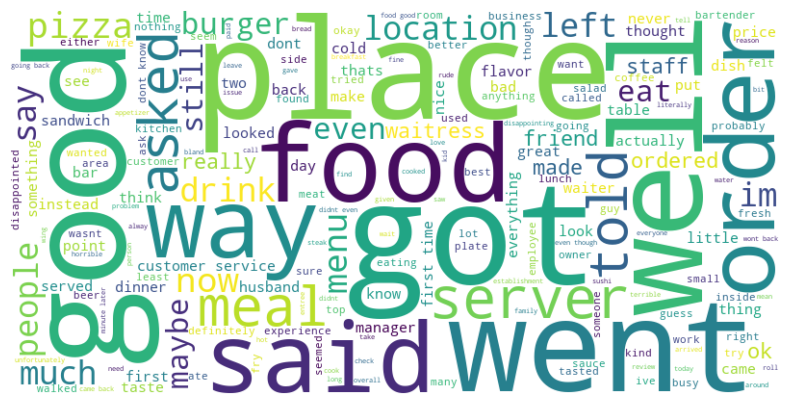

In [74]:

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.show()

# IV- BERTopic Model


#

In [ ]:
%%time
# BERTopic internally handles the SENTENCE EMBEDDING  process as part of its workflow

nr_topics= 4 + 1

#embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
#embedding_model = SentenceTransformer("stsb-roberta-large")
embedding_model = SentenceTransformer("all-MiniLM-L12-v2")


# Initialize the BERTopic model
topic_model = BERTopic(nr_topics= nr_topics, embedding_model=embedding_model)

# Fit the model to the preprocessed documents

topics, probs = topic_model.fit_transform(resto_reviews_df2['cleaned_reviews'].tolist())
#topics, probs = topic_model.fit_transform(filtered_df['cleaned_reviews'].tolist())


In [ ]:
# Save the trained BERTopic model to a file
topic_model.save("model_all_MiniLM_L12_v2.pkl")

In [16]:
print(topic_model.get_topic_info())

   Topic  Count                       Name  \
0     -1     10  -1_food_salsa_pizza_drink   

                                      Representation  \
0  [food, salsa, pizza, drink, even, ordered, bac...   

                                 Representative_Docs  
0  [straight point cheap taste feel cheap good pr...  


# IV- EMBEDDING


Convert the cleaned tokens into numerical features suitable for HDBSCAN. Typically, you use TF-IDF (Term Frequency-Inverse Document Frequency) or word embeddings like Word2Vec or BERT.



0    long term frequent customer establishment went...
1    least give restaurant two star due decent food...
2    straight point cheap taste feel cheap good pri...
3    want pay everything la carte place food wasnt ...
4    started artichoke dip big mistake cold chip st...
5    could give zero would order plain hamburger re...
6    visited disappointed veggie pizza husband sub ...
7    skip train wreck looking dinner server clueles...
8    meh say tds restaurant cold literally figurati...
9    service management terrible messing order wait...
Name: cleaned_reviews, dtype: object

# IV-B. DIMENSIONALITY REDUCTION

Apply dimensionality reduction techniques like PCA, Truncated SVD, or UMAP to reduce the feature space if necessary.

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X)


# V- Topic Modeling with HDBSCAN


In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
cluster_labels = clusterer.fit_predict(X_reduced)


# VI- CHARACTERIZE CLUSTERS OBTAINED FROM modeling with HDBSCAN

Based on the top words, representative documents, and visualizations, assign a descriptive label or name to each cluster. For example, a cluster with words like "data," "model," and "analysis" might be labeled "Data Analysis."



# VII-A. OPTION 1: Extract Top Words for Each Cluster

by Calculating the mean TF-IDF SCORES for EACH word WITHIN a cluster.
THEN Identifying the top n words with the highest scores that appea

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you have your text data and cluster labels
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(text_data)

cluster_labels = clusterer.labels_
n_clusters = np.unique(cluster_labels)

for cluster in n_clusters:
    if cluster == -1:  # Skip noise points
        continue
    cluster_indices = np.where(cluster_labels == cluster)
    cluster_tfidf = X[cluster_indices]
    mean_tfidf = np.mean(cluster_tfidf, axis=0)
    top_n_words = np.argsort(mean_tfidf.toarray()[0])[::-1][:10]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_n_words]
    print(f"Cluster {cluster}: {', '.join(top_words)}")


# VII-B. OPTION 2: Examine Representative DOCUMENTS

In [ ]:
# Select DOCUMENTS CLOSEST to the cluster CENTROID OR with the HIGHEST SIMILARITY to the CENTRAL topic
# THEN REVIEW MANUALLY THOSE KEY DOCUMENTS TO UNDERSTAND TOPICS 

for cluster in n_clusters:
    if cluster == -1:  # Skip noise points
        continue
    cluster_indices = np.where(cluster_labels == cluster)
    cluster_documents = X[cluster_indices]
    
    # Calculate centroid
    centroid = np.mean(cluster_documents, axis=0)
    similarities = cosine_similarity(centroid, cluster_documents)
    
    # Sort documents by similarity to the centroid
    sorted_indices = np.argsort(similarities[0])[::-1]
    top_documents = [text_data[cluster_indices[0][i]] for i in sorted_indices[:5]]
    
    print(f"Cluster {cluster} Representative Documents:")
    for doc in top_documents:
        print(doc[:200], '...')  # Print first 200 characters


# VII-C. OPTION 3: Word Clouds VISUALIZATION

In [ ]:
# visually represents the most frequent words in each cluster, giving a quick overview of the topic

from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cluster in n_clusters:
    if cluster == -1:
        continue
    cluster_indices = np.where(cluster_labels == cluster)
    cluster_text = " ".join([text_data[i] for i in cluster_indices[0]])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster} Word Cloud")
    plt.show()


# VIII- EVALUATE CLUSTERING

Check Cluster COHERENCE: Ensure that the identified themes are COHERENT and DISTINCT. 
If clusters seem too broad or OVERLAPPING, consider refining the PREPROCESSING steps or adjusting HDBSCAN PARAMETERS.

Iterate if Necessary: Topic modeling is often an iterative process. Adjust the steps, such as n-gram creation, stopword removal, or VECTORIZATION THECNIQUE techniques, based on the initial results.

In [18]:
def read_in_json_data_files(project_json_files_list):

    """
    Reads in a list of JSON data files specified in `project_json_files_list`, and returns a dictionary
    where each key corresponds to a file name without the extension, and the value is a list of JSON objects 
    from that file. Additionally, this function prints a summary table of the datasets read in, including 
    the number of objects in each dataset and their type.

    Parameters:
    project_json_files_list (list): A list of JSON file names to be read in. The files should be located 
    in the directory specified in the `p6_datafolder` variable.

    Returns:
    dict: A dictionary where each key corresponds to a file name without the extension, and the value is 
    a list of JSON objects from that file.

    Example:
    Given a list of project_json_files_list = ['file1.json', 'file2.json'], calling 
    read_in_json_data_files(project_json_files_list) will read in the JSON objects from both files and 
    return a dictionary with keys "file1" and "file2", and values corresponding to the lists of objects 
    read from each file.
    """  
    
    start_time = time.time()
    start_time_ = time.strftime("%H:%M:%S", time.localtime(start_time))
    print("Start time is  :", start_time_)


    datasets_dict = {}
    set_size_and_type = []

    for set_name in project_json_files_list:

        file_path_json    = p6_datafolder.joinpath(set_name)
        file_to_open_json = str(file_path_json)
        #print(file_to_open_json)

        data_list = [json.loads(line) for line in open(file_to_open_json, 'r', errors='replace') ]
        
        print()        
        list_elements_type = str(type(data_list[0]))[len(str(type(data_list[0])))-6: len(str(type(data_list[0])))-2]
        

        description = 'Contains a List of ' + "{:,.0f}".format(len(data_list)) +  " " + list_elements_type + "s"
        set_size_and_type.append(description)       

        dot_index = set_name.index(".")  # index of the "." in the list
        datasets_dict[set_name[0:dot_index]] = data_list
    

    sets_summary = {
        "Datasets": datasets_dict.keys(),
        "Description": set_size_and_type,
    }
    df_datasets_description = pd.DataFrame(sets_summary)
    print()
    print(df_datasets_description)
    
    print()
    print("Current time is:", time.strftime("%H:%M:%S", time.localtime()))
    print(
        "Total time elapsed = %s HH:MM:SS "
        % time.strftime("%H:%M:%S", time.gmtime((time.time() - start_time)))
    )

    return datasets_dict


In [ ]:
import chardet

# Read a sample of the file to detect encoding
with open(file_path, 'rb') as file:
    sample = file.read(10000)  # Adjust the size of the sample if needed
    result = chardet.detect(sample)

In [11]:

yelp_reviews_dict={}


file_path = 'yelp_dataset'

# Open the file and parse incrementally
with open(file_path, 'r') as file:
    parser = ijson.parse(file)
    for prefix, event, value in parser:
        if (prefix.endswith('item') and event == 'map_key'):
            #print(f'Key: {value}')
            dict_key = value
        elif (prefix.endswith('item') and event == 'string'):
            #print(f'Value: {value}')
            dict_value = value
            
        yelp_reviews_dict[dict_key] = dict_value


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd3 in position 522: invalid continuation byte

In [ ]:
# Path to your JSON file
file_path = 'yelp_dataset'

# Open the JSON file and load it into a dictionary
with open(file_path, 'r') as file:
    data = json.load(file)